## Impot Modul

In [2]:
import pandas as pd
import numpy as np
import os, glob
import sys
import librosa
import librosa.display
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio



## Akses Dataset

In [3]:
dataset_path = "dataset/TESS Toronto emotional speech set data"

emotions_map = {
    "angry": "angry",
    "disgust": "disgust",
    "fear": "fear",
    "happy": "happy",
    "neutral": "neutral",
    "pleasant_surprise": "surprise",
    "sad": "sad",
}

data = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            folder_name = os.path.basename(root)
            for key in emotions_map.keys():
                if key in folder_name.lower():
                    emotion_label = emotions_map[key]
                    file_path = os.path.join(root, file)
                    data.append({"emotion": emotion_label, "Path": file_path})
                    break

df = pd.DataFrame(data)
df


,emotion,Path
0,angry,dataset/TESS Toronto emotional speech set data...
1,angry,dataset/TESS Toronto emotional speech set data...
2,angry,dataset/TESS Toronto emotional speech set data...
3,angry,dataset/TESS Toronto emotional speech set data...
4,angry,dataset/TESS Toronto emotional speech set data...
...,...,...
2795,sad,dataset/TESS Toronto emotional speech set data...
2796,sad,dataset/TESS Toronto emotional speech set data...
2797,sad,dataset/TESS Toronto emotional speech set data...
2798,sad,dataset/TESS Toronto emotional speech set data...


## Cek Kategori Emosi

In [4]:
df
ok = df['emotion']
ok.unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'surprise', 'sad'],
      dtype=object)

## Hitung Jumlah Setiap Kategori

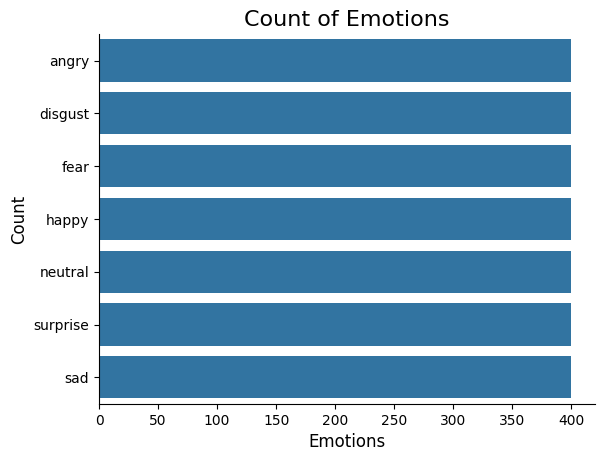

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(df.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Visual Gelombang Amplitudo

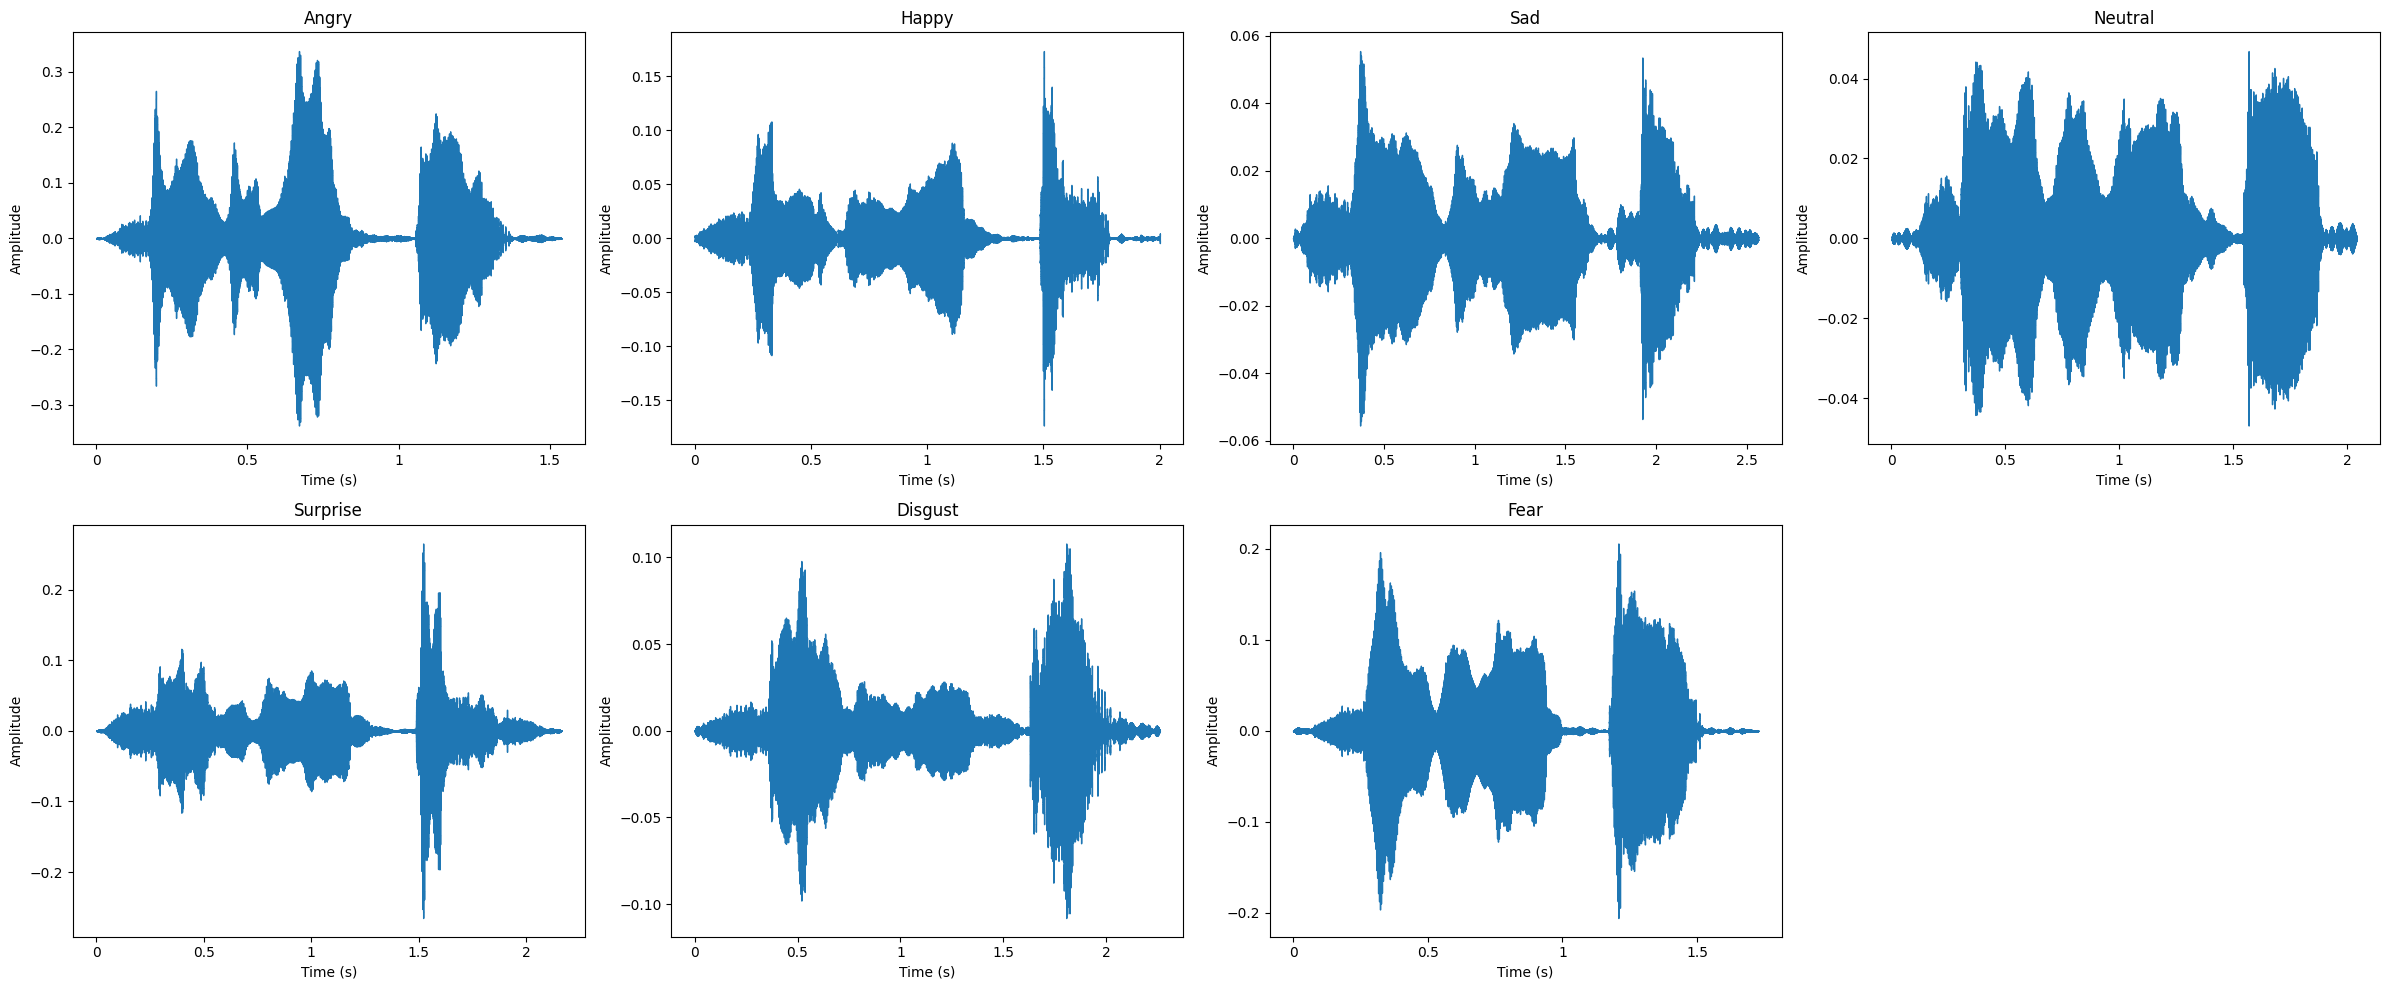

In [6]:
import soundfile
import librosa.display
import matplotlib.pyplot as plt

file_paths = {
    "angry": "dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav",
    "happy": "dataset/TESS Toronto emotional speech set data/OAF_happy/OAF_back_happy.wav",
    "sad": "dataset/TESS Toronto emotional speech set data/OAF_sad/OAF_back_sad.wav",
    "neutral": "dataset/TESS Toronto emotional speech set data/OAF_neutral/OAF_back_neutral.wav",
    "surprise": "dataset/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_base_ps.wav",
    "disgust": "dataset/TESS Toronto emotional speech set data/OAF_disgust/OAF_back_disgust.wav",
    "fear": "dataset/TESS Toronto emotional speech set data/OAF_fear/OAF_back_fear.wav",
}
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

for idx, (emotion, file_path) in enumerate(file_paths.items()):
    with soundfile.SoundFile(file_path) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        librosa.display.waveshow(waveform, sr=sample_rate, ax=axes[idx])
        axes[idx].set_title(emotion.capitalize(), fontsize=12)
        axes[idx].set_xlabel("Time (s)", fontsize=10)
        axes[idx].set_ylabel("Amplitude", fontsize=10)

for idx in range(len(file_paths), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


## Cek Min dan Max Pitch Audio Emosi

In [7]:
import os
import pandas as pd
import librosa
import numpy as np

dataset_path = "dataset/TESS Toronto emotional speech set data"
emotions_map = {
    "angry": "angry",
    "disgust": "disgust",
    "fear": "fear",
    "happy": "happy",
    "neutral": "neutral",
    "pleasant_surprise": "surprise",
    "sad": "sad",
}

data = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            folder_name = os.path.basename(root)
            for key in emotions_map.keys():
                if key in folder_name.lower():
                    emotion_label = emotions_map[key]
                    file_path = os.path.join(root, file)
                    data.append({"emotion": emotion_label, "Path": file_path})
                    break
df = pd.DataFrame(data)

def measure_pitch(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitches = pitches[magnitudes > np.median(magnitudes)]
        if len(pitches) > 0:
            return np.min(pitches), np.max(pitches)
        return None, None
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

samples = []
for emotion in emotions_map.values():
    sample = df[df['emotion'] == emotion].sample(1, random_state=42)
    for _, row in sample.iterrows():
        min_pitch, max_pitch = measure_pitch(row['Path'])
        samples.append({
            "Emotion": emotion,
            "File Path": row['Path'],
            "Min Pitch (Hz)": min_pitch,
            "Max Pitch (Hz)": max_pitch
        })
samples_df = pd.DataFrame(samples)
samples_df



,Emotion,File Path,Min Pitch (Hz),Max Pitch (Hz)
0,angry,dataset/TESS Toronto emotional speech set data...,150.423035,3998.889160
1,disgust,dataset/TESS Toronto emotional speech set data...,149.046051,3992.997803
2,fear,dataset/TESS Toronto emotional speech set data...,151.113052,3992.800293
3,happy,dataset/TESS Toronto emotional speech set data...,153.343781,3994.332520
4,neutral,dataset/TESS Toronto emotional speech set data...,165.502838,3997.137939
5,surprise,dataset/TESS Toronto emotional speech set data...,166.456940,3997.749756
6,sad,dataset/TESS Toronto emotional speech set data...,157.189560,3948.957275


## Preprocessing Audio

In [8]:
def process_audio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        y_denoised = librosa.effects.preemphasis(y)
        y_normalized = y_denoised / np.max(np.abs(y_denoised))
        frame_length = int(0.03 * sr)  
        hop_length = int(0.01 * sr) 
        frames = librosa.util.frame(y_normalized, frame_length=frame_length, hop_length=hop_length).T
        hamming_window = np.hamming(frame_length)
        windowed_frames = frames * hamming_window
        energy = np.sum(windowed_frames**2, axis=1)
        threshold = np.mean(energy) * 0.5  
        voiced_frames = windowed_frames[energy > threshold]

        return voiced_frames, sr
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

processed_data = []
for _, row in df.iterrows():
    voiced_frames, sr = process_audio(row['Path'])
    if voiced_frames is not None:
        processed_data.append({
            "emotion": row["emotion"],
            "Path": row["Path"],
            "Sample Rate": sr,
            "Processed Frames": voiced_frames.shape[0]
        })
processed_df = pd.DataFrame(processed_data)
processed_df


,emotion,Path,Sample Rate,Processed Frames
0,angry,dataset/TESS Toronto emotional speech set data...,24414,68
1,angry,dataset/TESS Toronto emotional speech set data...,24414,79
2,angry,dataset/TESS Toronto emotional speech set data...,24414,65
3,angry,dataset/TESS Toronto emotional speech set data...,24414,76
4,angry,dataset/TESS Toronto emotional speech set data...,24414,71
...,...,...,...,...
2795,sad,dataset/TESS Toronto emotional speech set data...,24414,69
2796,sad,dataset/TESS Toronto emotional speech set data...,24414,40
2797,sad,dataset/TESS Toronto emotional speech set data...,24414,74
2798,sad,dataset/TESS Toronto emotional speech set data...,24414,50


## Visual Hasil Preprocessing Audio

C:\Users\LOQ\AppData\Local\Temp\ipykernel_18024\3347261629.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = processed_df.groupby("emotion").apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


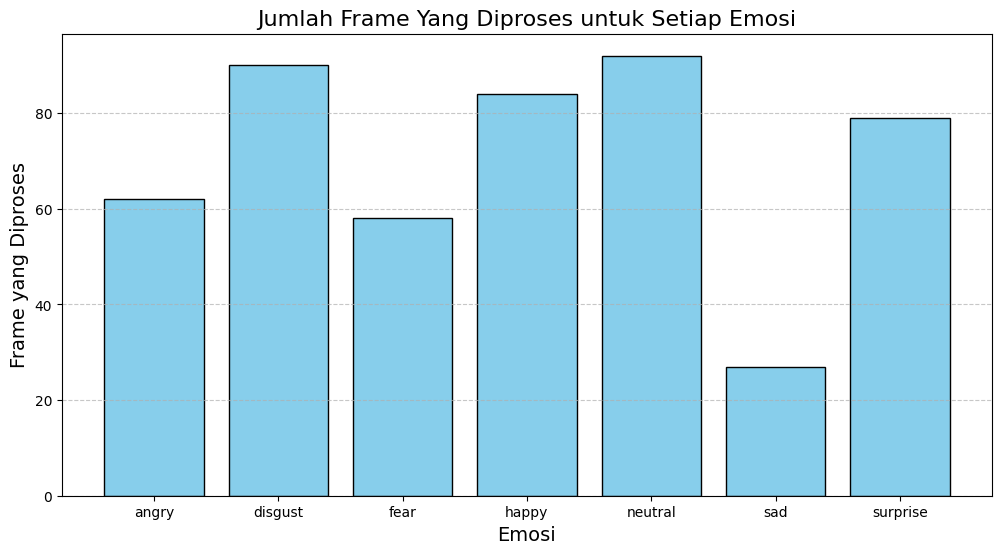

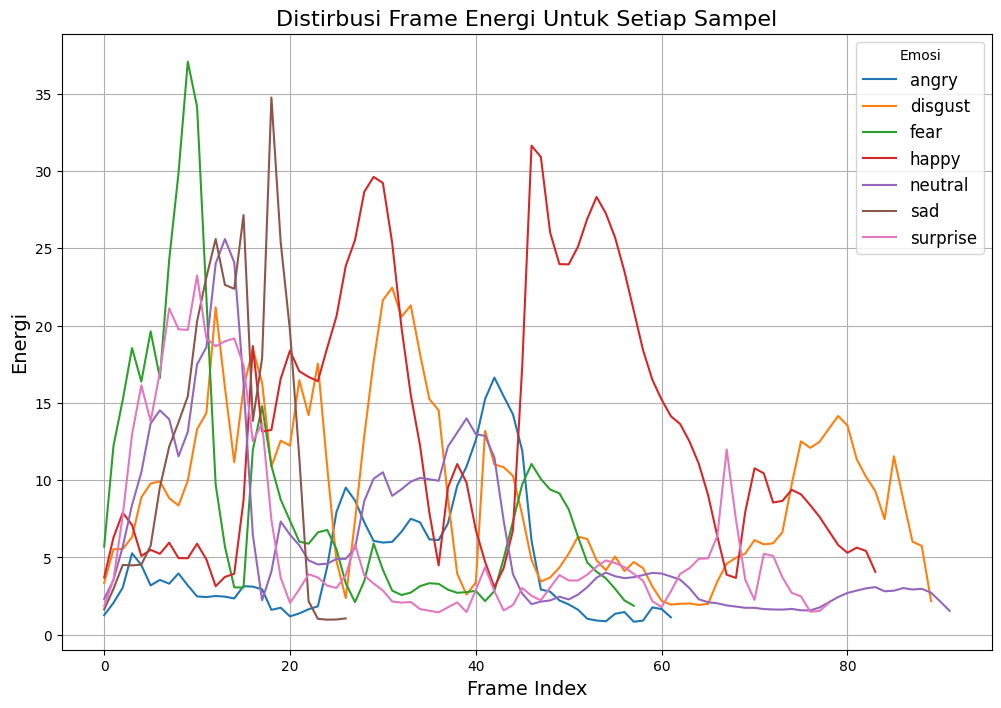

In [9]:
import matplotlib.pyplot as plt

sampled_data = processed_df.groupby("emotion").apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.bar(sampled_data["emotion"], sampled_data["Processed Frames"], color='skyblue', edgecolor='black')
plt.title("Jumlah Frame Yang Diproses untuk Setiap Emosi", fontsize=16)
plt.xlabel("Emosi", fontsize=14)
plt.ylabel("Frame yang Diproses", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 8))
for _, row in sampled_data.iterrows():
    voiced_frames, _ = process_audio(row["Path"])
    energies = np.sum(voiced_frames**2, axis=1)
    plt.plot(energies, label=row["emotion"])

plt.title("Distirbusi Frame Energi Untuk Setiap Sampel", fontsize=16)
plt.xlabel("Frame Index", fontsize=14)
plt.ylabel("Energi", fontsize=14)
plt.legend(title="Emosi", fontsize=12)
plt.grid(True)
plt.show()

## Ekstraksi FItur 

In [10]:
import librosa
import numpy as np
import pandas as pd


def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        
        delta_mfcc = librosa.feature.delta(mfcc)
        
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        rms = librosa.feature.rms(y=y)  
        duration = librosa.get_duration(y=y, sr=sr)

        stft = np.abs(librosa.stft(y))

        fft = np.fft.fft(y)

        z_transform = librosa.core.amplitude_to_db(np.abs(fft))

        zcr = librosa.feature.zero_crossing_rate(y=y)

        features = {
            "MFCC Mean": np.mean(mfcc, axis=1),
            "Delta MFCC Mean": np.mean(delta_mfcc, axis=1),
            "Chroma Mean": np.mean(chroma, axis=1),
            "RMS Energy Mean": np.mean(rms),
            "Duration": duration,
            "STFT Mean": np.mean(stft, axis=1),
            "FFT Mean": np.mean(np.abs(fft)),
            "Z Transform Mean": np.mean(z_transform),
            "Zero Crossing Rate Mean": np.mean(zcr),
        }
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

extracted_features = []
for _, row in df.iterrows():
    features = extract_features(row['Path'])
    if features:
        features["emotion"] = row["emotion"]
        features["Path"] = row["Path"]
        extracted_features.append(features)

features_df = pd.DataFrame(extracted_features)
features_df.head()

,MFCC Mean,Delta MFCC Mean,Chroma Mean,RMS Energy Mean,Duration,STFT Mean,FFT Mean,Z Transform Mean,Zero Crossing Rate Mean,emotion,Path
0,"[-390.03134, 55.235966, -15.03465, -10.704581,...","[-0.1151213, 0.5525284, -0.19031347, -0.161042...","[0.5123848, 0.26657137, 0.1694559, 0.20645961,...",0.041406,1.539035,"[1.5966268, 1.0541798, 0.47731256, 0.23370263,...",2.991938,-1.344355,0.081048,angry,dataset/TESS Toronto emotional speech set data...
1,"[-451.01947, 67.04882, -0.44825754, -16.81213,...","[-0.026987858, 0.63351494, 0.08885835, -0.3026...","[0.5681136, 0.41696244, 0.2415403, 0.23117633,...",0.022364,1.616613,"[1.1482664, 0.9635808, 0.5883991, 0.22436398, ...",1.750080,-5.270053,0.085180,angry,dataset/TESS Toronto emotional speech set data...
2,"[-406.56332, 28.609005, -5.3172164, 2.1246307,...","[1.4253249, -0.32651868, 0.08163461, -0.210981...","[0.3994932, 0.50156957, 0.3047032, 0.23284735,...",0.029732,1.542025,"[1.5226669, 1.0766797, 0.5382729, 0.18880948, ...",2.585556,-0.981459,0.127679,angry,dataset/TESS Toronto emotional speech set data...
3,"[-386.34006, 53.439655, -8.663545, -13.309979,...","[-0.11889985, 0.0797428, 0.23381248, -0.462038...","[0.45679557, 0.29842108, 0.18600088, 0.1966973...",0.043054,1.606865,"[1.8433156, 1.2605739, 0.5070227, 0.19850749, ...",3.049630,-0.618676,0.105919,angry,dataset/TESS Toronto emotional speech set data...
4,"[-404.78488, 54.462566, 3.3552904, 10.96758, 2...","[0.17272753, 3.370405, 0.6712302, -0.46541652,...","[0.28821033, 0.48215002, 0.42801937, 0.321111,...",0.030544,1.395183,"[1.509937, 1.2596105, 0.67515755, 0.22007048, ...",2.115893,-3.292133,0.076019,angry,dataset/TESS Toronto emotional speech set data...


## Visualisasi Hasil Ekstraksi Fitur

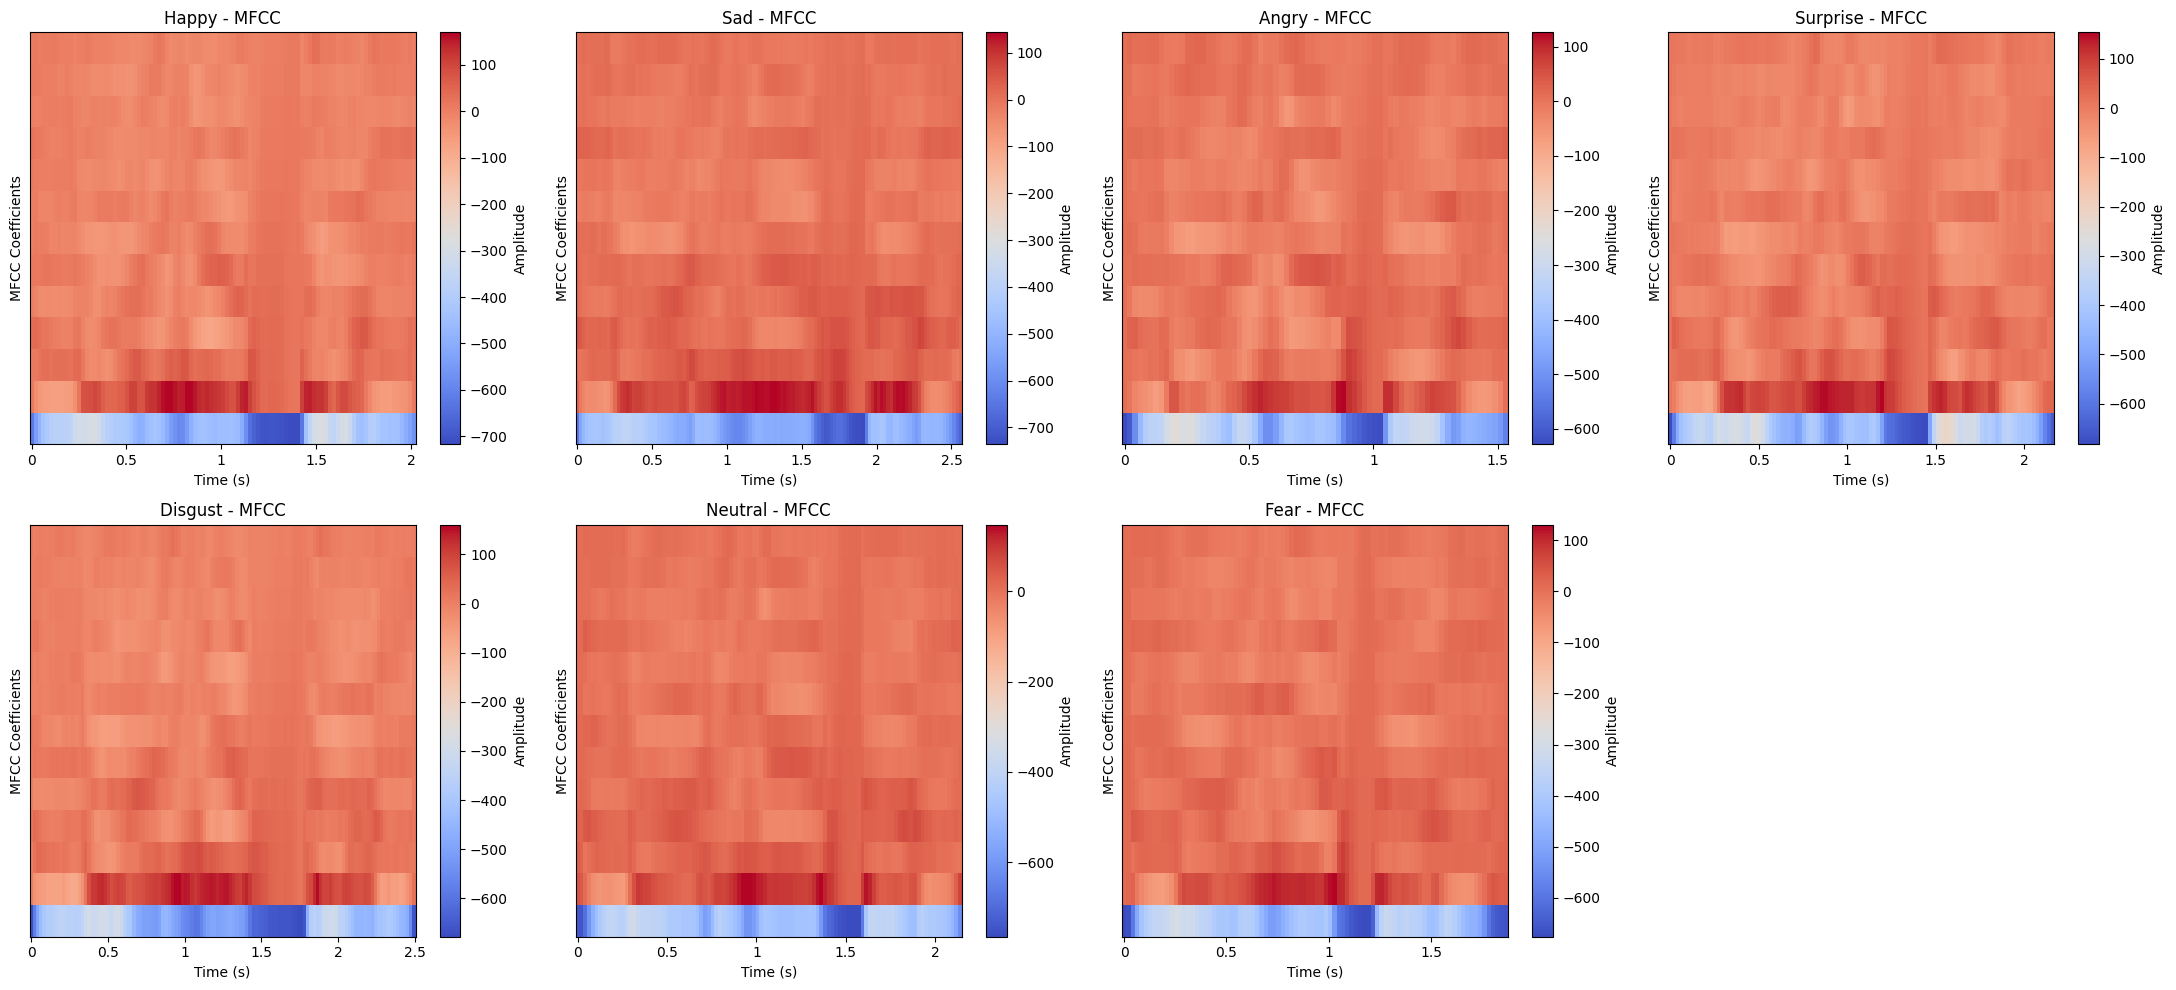

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_mfcc(ax, file_path, emotion_title):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    img = librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap='coolwarm', ax=ax)
    ax.set_title(f"{emotion_title.capitalize()} - MFCC", fontsize=12)
    ax.set_xlabel("Time (s)", fontsize=10)
    ax.set_ylabel("MFCC Coefficients", fontsize=10)
    plt.colorbar(img, ax=ax, label='Amplitude')

file_paths = {
    "happy": "dataset/TESS Toronto emotional speech set data/OAF_happy/OAF_base_happy.wav",
    "sad": "dataset/TESS Toronto emotional speech set data/OAF_Sad/OAF_base_sad.wav",
    "angry": "dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav",
    "surprise": "dataset/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_base_ps.wav",
    "disgust": "dataset/TESS Toronto emotional speech set data/OAF_disgust/OAF_base_disgust.wav",
    "neutral": "dataset/TESS Toronto emotional speech set data/OAF_neutral/OAF_base_neutral.wav",
    "fear": "dataset/TESS Toronto emotional speech set data/OAF_fear/OAF_base_fear.wav",
}
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (emotion, path) in enumerate(file_paths.items()):
    plot_mfcc(axes[idx], path, emotion)

for idx in range(len(file_paths), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


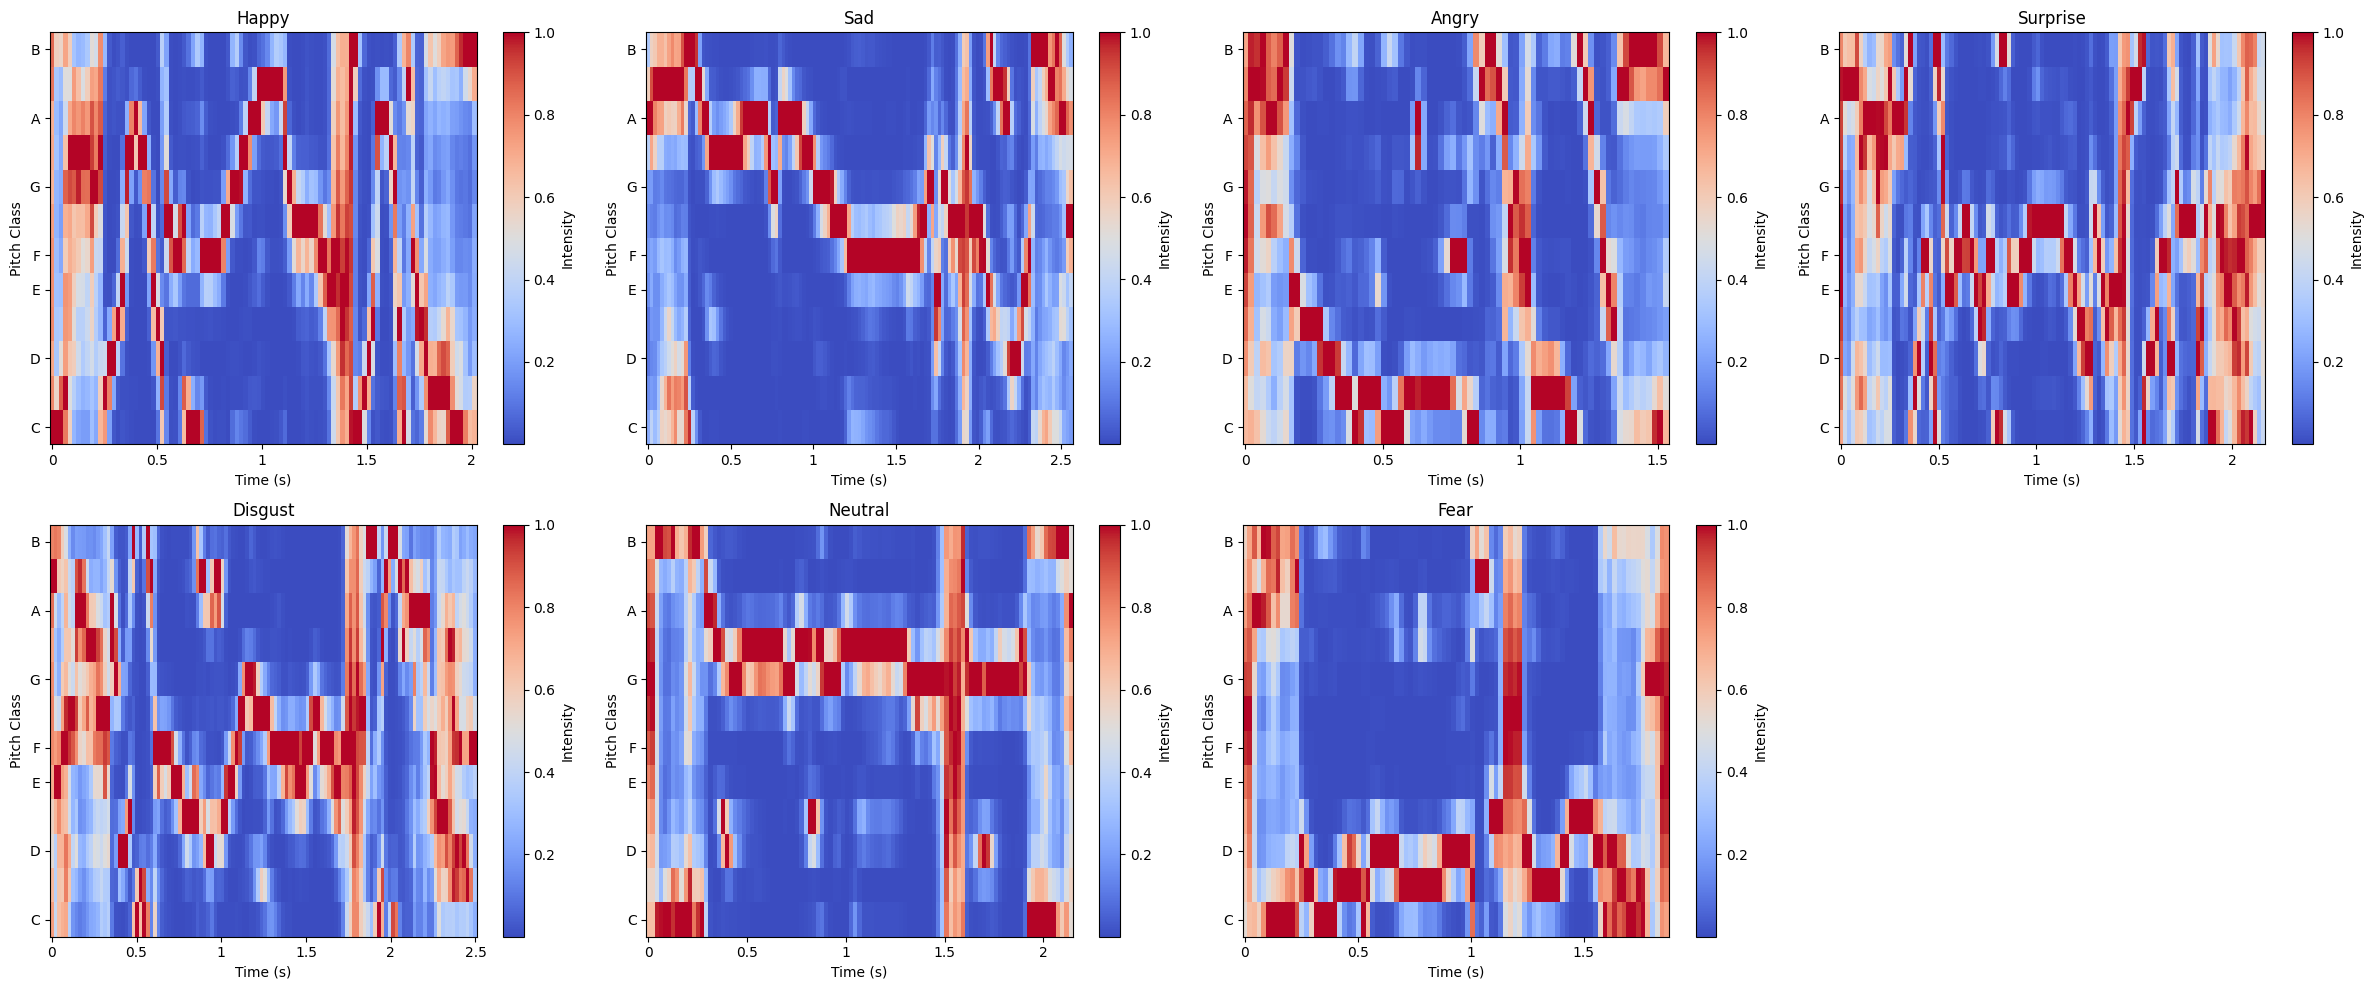

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np


def plot_chroma(ax, file_path, emotion_title):
    y, sr = librosa.load(file_path, sr=None)
    chroma = librosa.feature.chroma_stft(y=y + 1e-6, sr=sr)
    chroma = np.nan_to_num(chroma)
    img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='coolwarm', sr=sr, ax=ax)
    ax.set_title(f"{emotion_title.capitalize()}", fontsize=12)
    ax.set_xlabel("Time (s)", fontsize=10)
    ax.set_ylabel("Pitch Class", fontsize=10)
    plt.colorbar(img, ax=ax, label='Intensity')

file_paths = {
    "happy": "dataset/TESS Toronto emotional speech set data/OAF_happy/OAF_base_happy.wav",
    "sad": "dataset/TESS Toronto emotional speech set data/OAF_Sad/OAF_base_sad.wav",
    "angry": "dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav",
    "surprise": "dataset/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_base_ps.wav",
    "disgust": "dataset/TESS Toronto emotional speech set data/OAF_disgust/OAF_base_disgust.wav",
    "neutral": "dataset/TESS Toronto emotional speech set data/OAF_neutral/OAF_base_neutral.wav",
    "fear": "dataset/TESS Toronto emotional speech set data/OAF_fear/OAF_base_fear.wav",
}
fig, axes = plt.subplots(2, 4, figsize=(24, 10)) 
axes = axes.flatten()

for idx, (emotion, path) in enumerate(file_paths.items()):
    plot_chroma(axes[idx], path, emotion)

for idx in range(len(file_paths), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


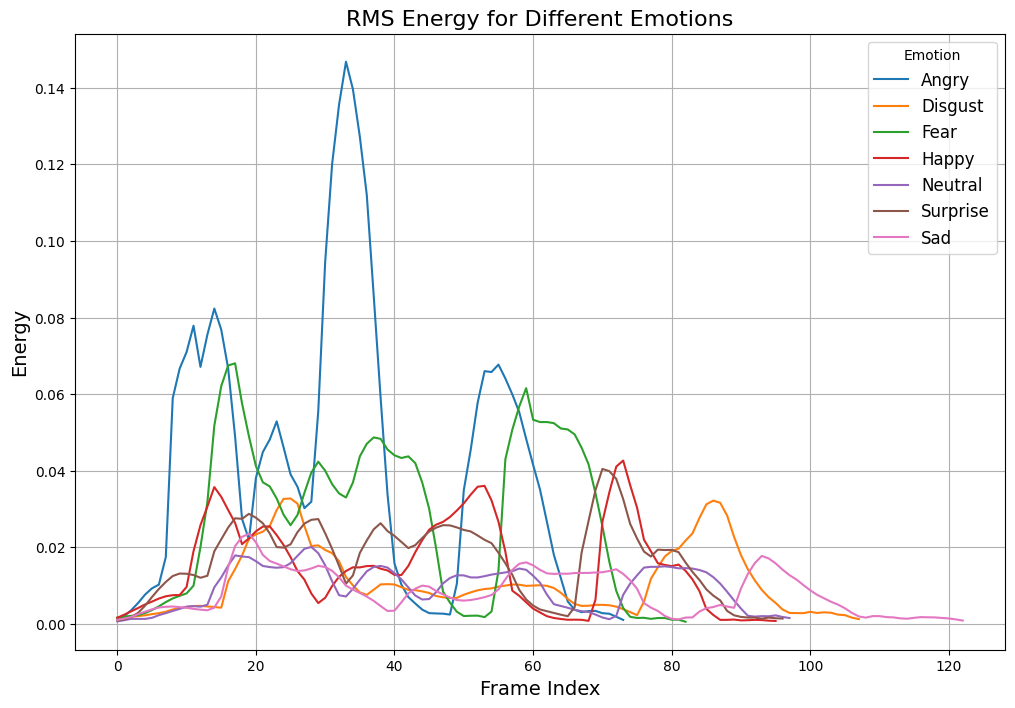

In [13]:
import librosa
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for emotion in features_df["emotion"].unique():
    file_path = features_df[features_df["emotion"] == emotion].iloc[0]["Path"]
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y)
    plt.plot(rms[0], label=emotion.capitalize())

plt.title("RMS Energy for Different Emotions", fontsize=16)
plt.xlabel("Frame Index", fontsize=14)
plt.ylabel("Energy", fontsize=14)
plt.grid(True)
plt.legend(title="Emotion", fontsize=12)
plt.show()


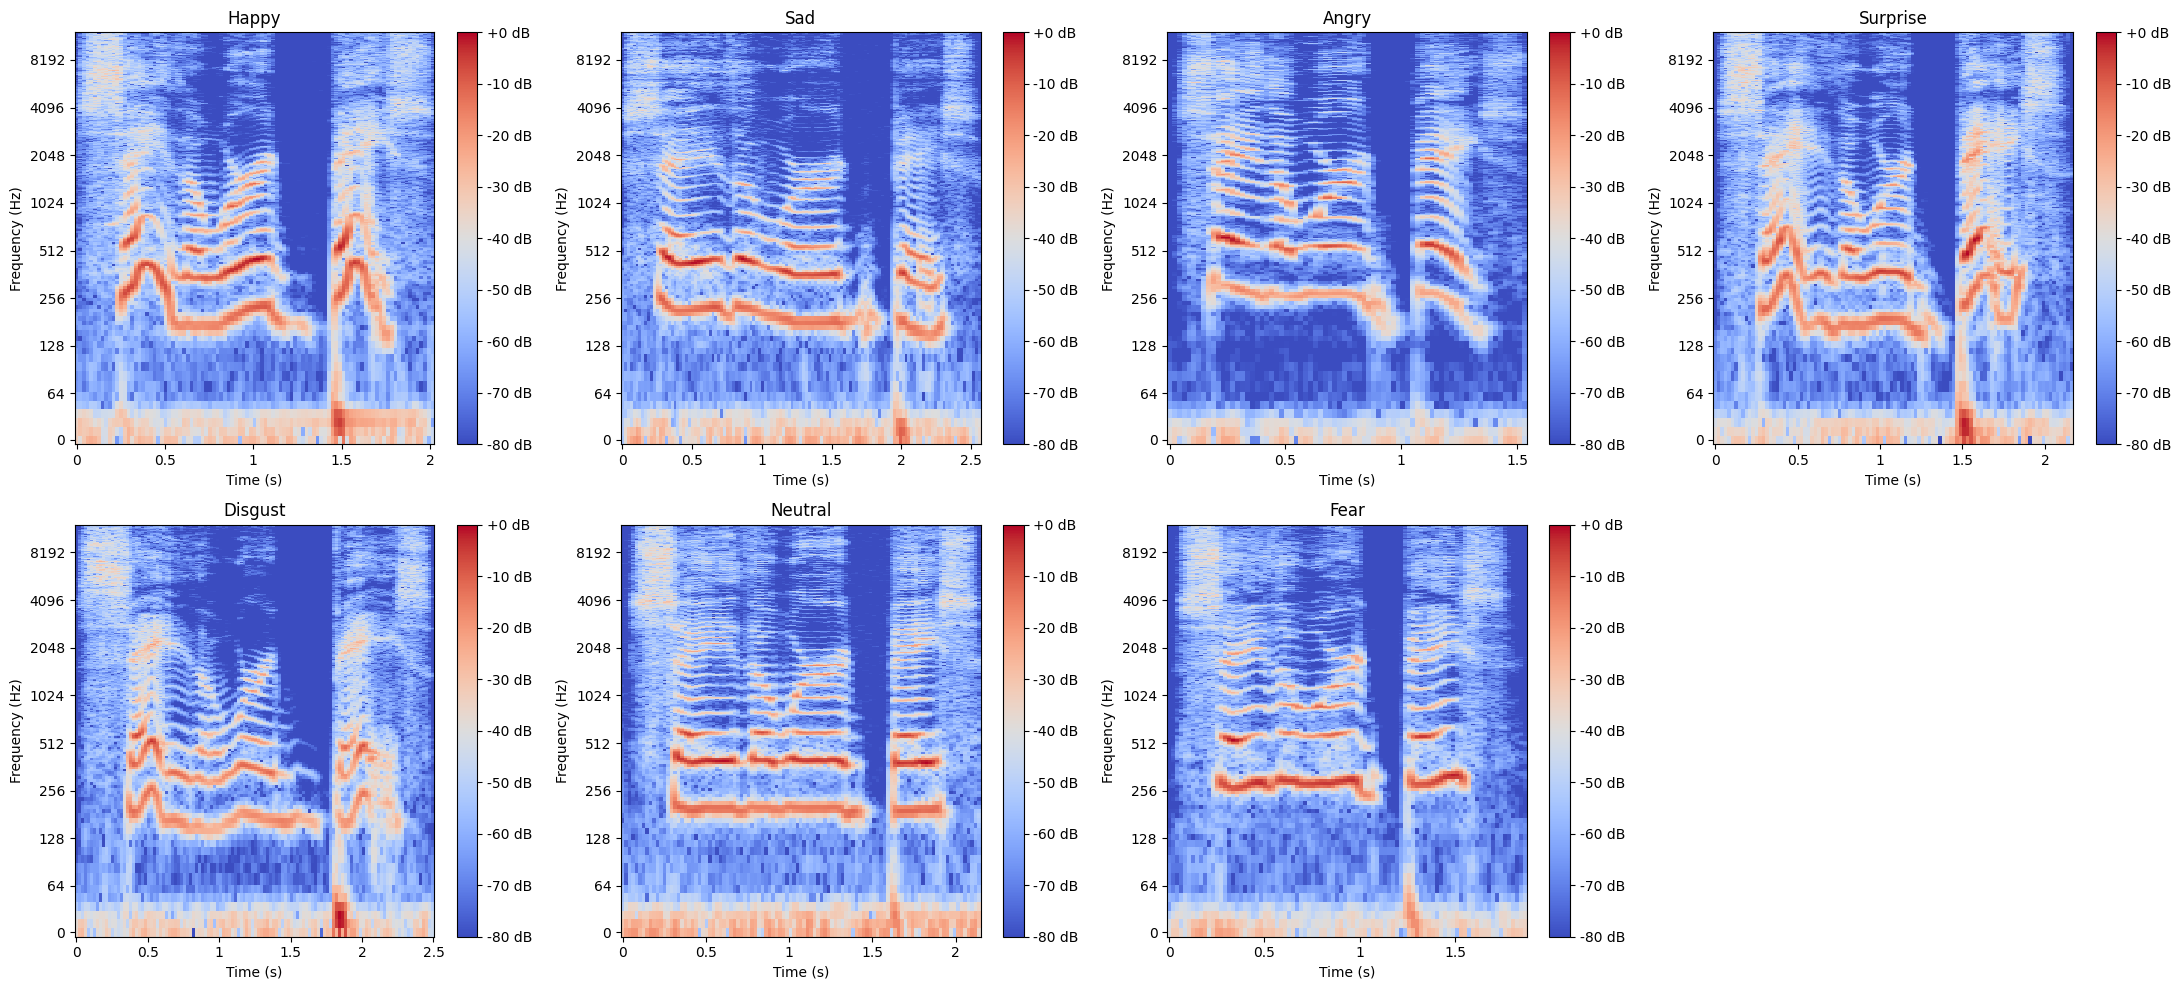

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_stft(ax, file_path, emotion_title):
    y, sr = librosa.load(file_path, sr=None)
    stft = np.abs(librosa.stft(y))
    db_stft = librosa.amplitude_to_db(stft, ref=np.max)

    img = librosa.display.specshow(db_stft, sr=sr, x_axis="time", y_axis="log", cmap="coolwarm", ax=ax)
    ax.set_title(f"{emotion_title.capitalize()}", fontsize=12)
    ax.set_xlabel("Time (s)", fontsize=10)
    ax.set_ylabel("Frequency (Hz)", fontsize=10)
    plt.colorbar(img, ax=ax, format="%+2.0f dB")

file_paths = {
    "happy": "dataset/TESS Toronto emotional speech set data/OAF_happy/OAF_base_happy.wav",
    "sad": "dataset/TESS Toronto emotional speech set data/OAF_Sad/OAF_base_sad.wav",
    "angry": "dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav",
    "surprise": "dataset/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_base_ps.wav",
    "disgust": "dataset/TESS Toronto emotional speech set data/OAF_disgust/OAF_base_disgust.wav",
    "neutral": "dataset/TESS Toronto emotional speech set data/OAF_neutral/OAF_base_neutral.wav",
    "fear": "dataset/TESS Toronto emotional speech set data/OAF_fear/OAF_base_fear.wav",
}

fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten() 

for idx, (emotion, path) in enumerate(file_paths.items()):
    plot_stft(axes[idx], path, emotion)

for idx in range(len(file_paths), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


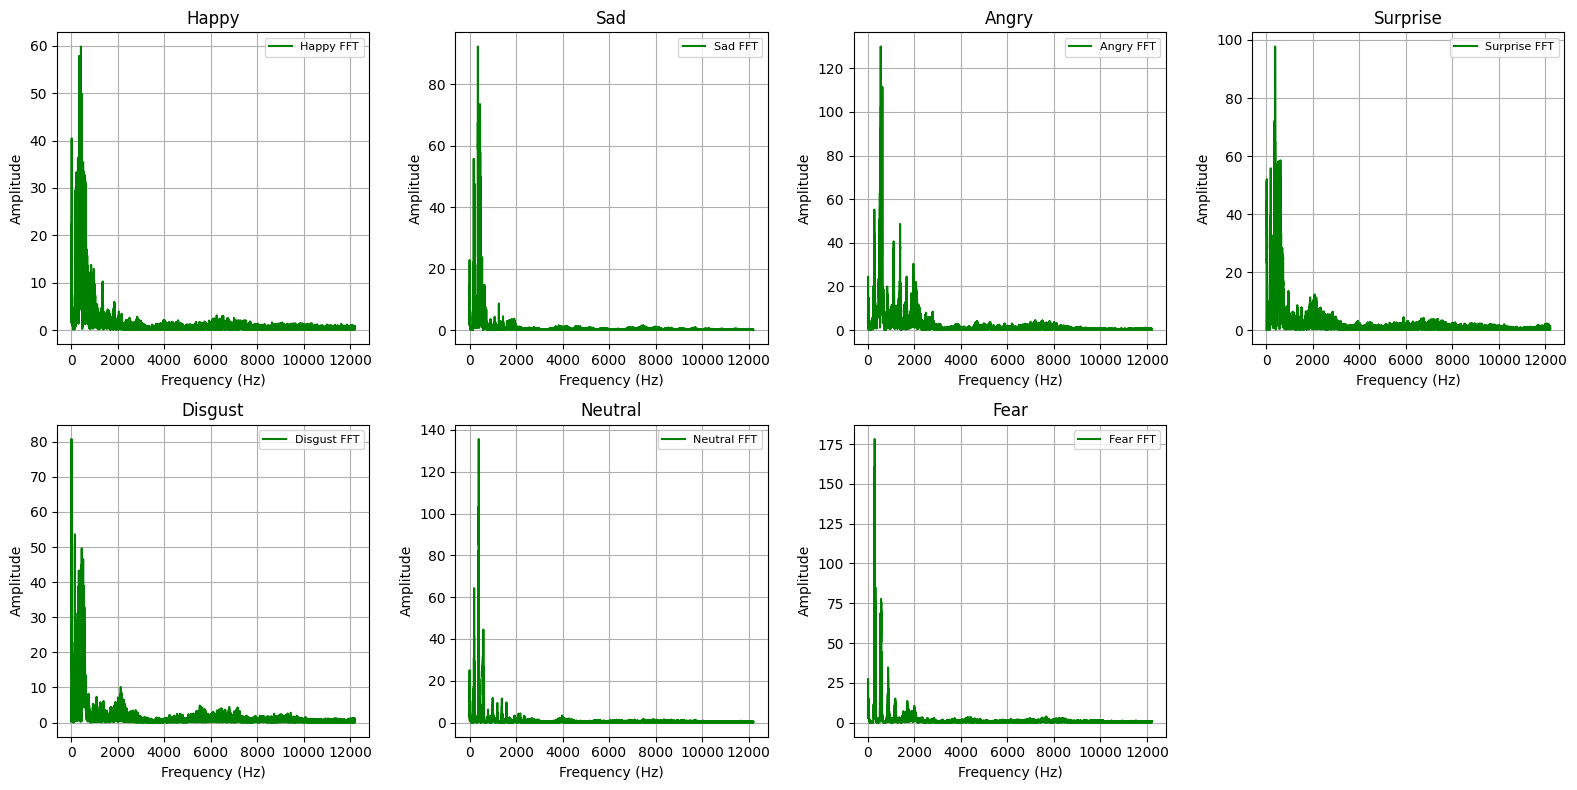

In [15]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

def plot_fft(ax, file_path, emotion_title):
    y, sr = librosa.load(file_path, sr=None)
    fft = np.abs(np.fft.fft(y))[:len(y)//2]
    frequencies = np.fft.fftfreq(len(y), 1/sr)[:len(y)//2]
    
    ax.plot(frequencies, fft, label=f"{emotion_title.capitalize()} FFT", color="green")
    ax.set_title(f"{emotion_title.capitalize()}", fontsize=12)
    ax.set_xlabel("Frequency (Hz)", fontsize=10)
    ax.set_ylabel("Amplitude", fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8)

file_paths = {
    "happy": "dataset/TESS Toronto emotional speech set data/OAF_happy/OAF_base_happy.wav",
    "sad": "dataset/TESS Toronto emotional speech set data/OAF_Sad/OAF_base_sad.wav",
    "angry": "dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav",
    "surprise": "dataset/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_base_ps.wav",
    "disgust": "dataset/TESS Toronto emotional speech set data/OAF_disgust/OAF_base_disgust.wav",
    "neutral": "dataset/TESS Toronto emotional speech set data/OAF_neutral/OAF_base_neutral.wav",
    "fear": "dataset/TESS Toronto emotional speech set data/OAF_fear/OAF_base_fear.wav",
}
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()  

for idx, (emotion, path) in enumerate(file_paths.items()):
    plot_fft(axes[idx], path, emotion)

for idx in range(len(file_paths), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


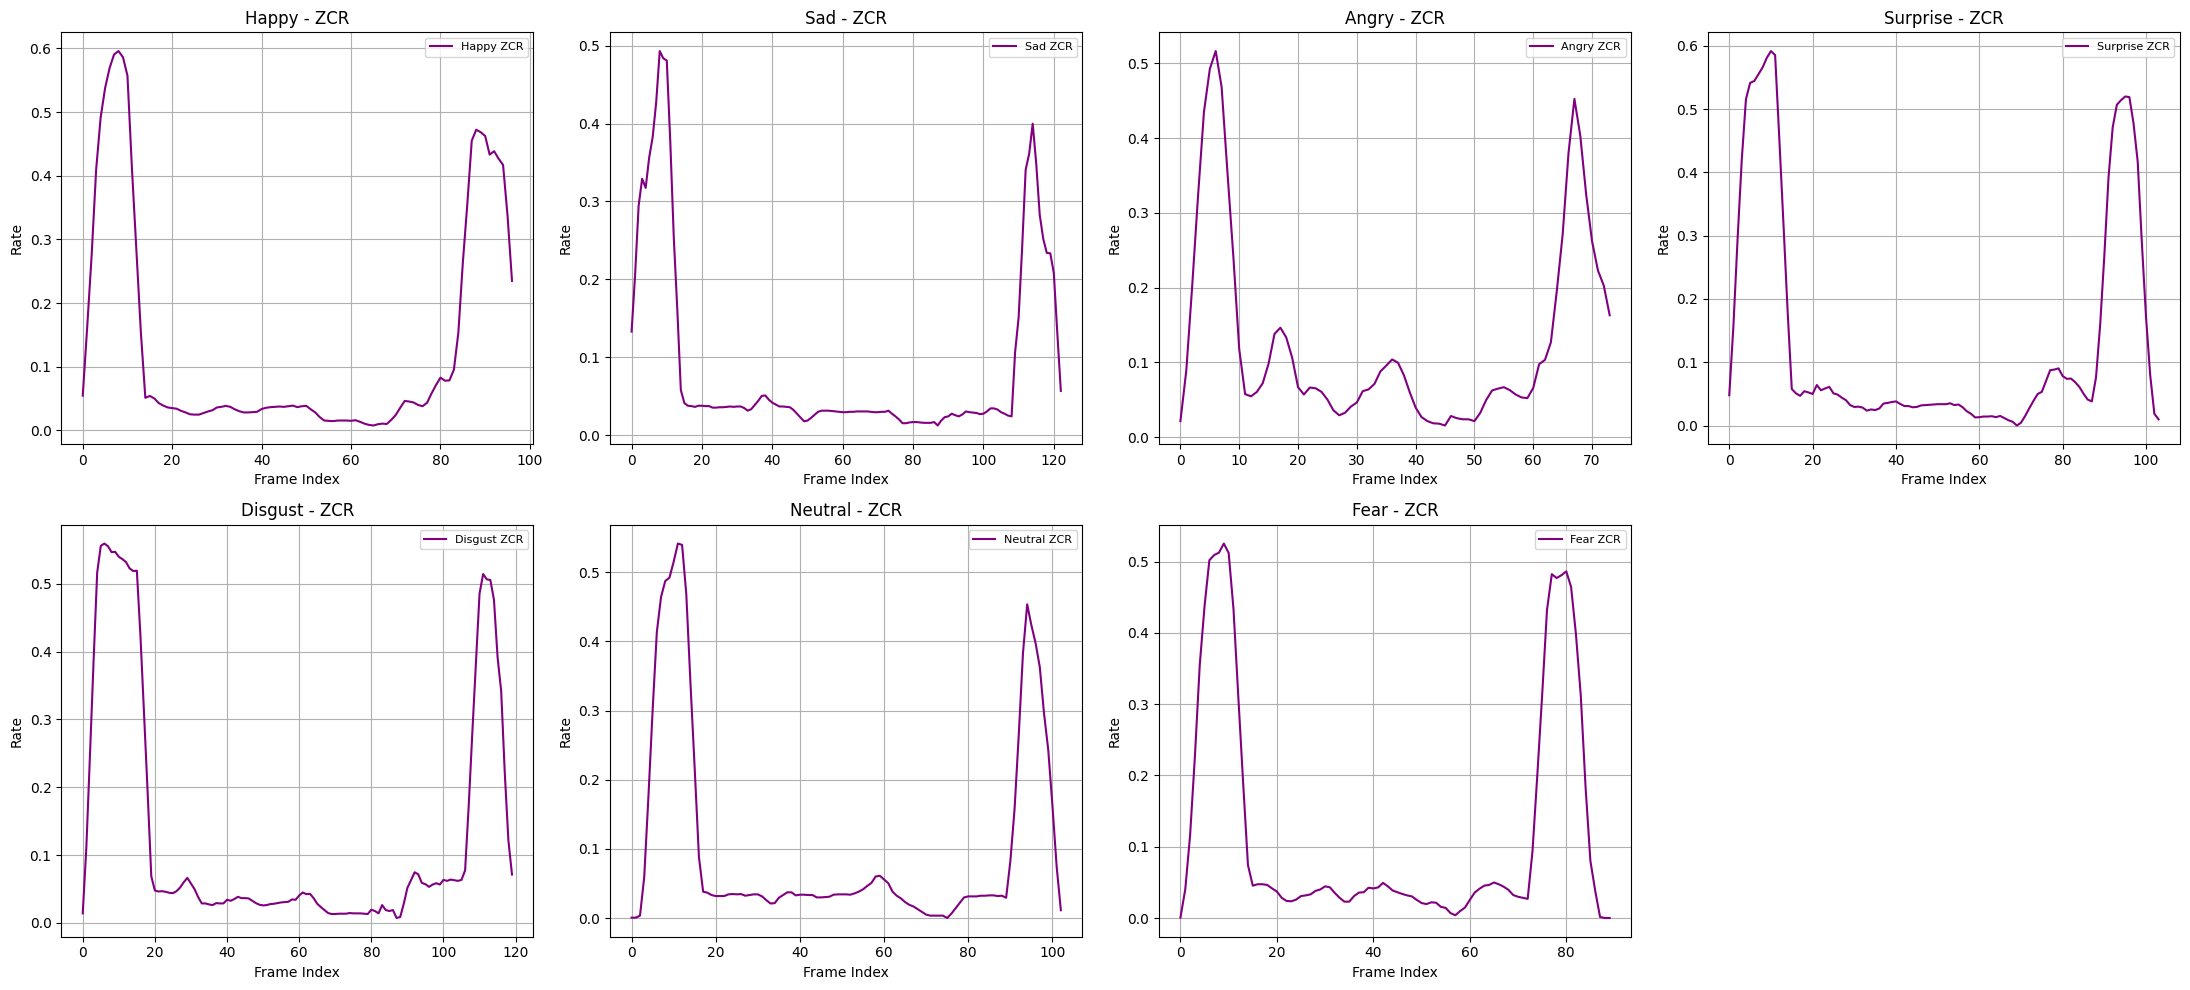

In [16]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

def plot_zcr(ax, file_path, emotion_title):
    y, sr = librosa.load(file_path, sr=None)
    zcr = librosa.feature.zero_crossing_rate(y=y)
    
    ax.plot(zcr[0], label=f"{emotion_title.capitalize()} ZCR", color="purple")
    ax.set_title(f"{emotion_title.capitalize()} - ZCR", fontsize=12)
    ax.set_xlabel("Frame Index", fontsize=10)
    ax.set_ylabel("Rate", fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8)

file_paths = {
    "happy": "dataset/TESS Toronto emotional speech set data/OAF_happy/OAF_base_happy.wav",
    "sad": "dataset/TESS Toronto emotional speech set data/OAF_Sad/OAF_base_sad.wav",
    "angry": "dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav",
    "surprise": "dataset/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_base_ps.wav",
    "disgust": "dataset/TESS Toronto emotional speech set data/OAF_disgust/OAF_base_disgust.wav",
    "neutral": "dataset/TESS Toronto emotional speech set data/OAF_neutral/OAF_base_neutral.wav",
    "fear": "dataset/TESS Toronto emotional speech set data/OAF_fear/OAF_base_fear.wav",
}
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (emotion, path) in enumerate(file_paths.items()):
    plot_zcr(axes[idx], path, emotion)

for idx in range(len(file_paths), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [28]:
dataset_path = "dataset/TESS Toronto emotional speech set data"

emotions_map = {
    "angry": "angry",
    "disgust": "disgust",
    "fear": "fear",
    "happy": "happy",
    "neutral": "neutral",
    "pleasant_surprise": "surprise",
    "sad": "sad",
}

data = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            folder_name = os.path.basename(root)
            for key in emotions_map.keys():
                if key in folder_name.lower():
                    emotion_label = emotions_map[key]
                    file_path = os.path.join(root, file)
                    data.append({"emotion": emotion_label, "Path": file_path})
                    break

df = pd.DataFrame(data)
df


,emotion,Path
0,angry,dataset/TESS Toronto emotional speech set data...
1,angry,dataset/TESS Toronto emotional speech set data...
2,angry,dataset/TESS Toronto emotional speech set data...
3,angry,dataset/TESS Toronto emotional speech set data...
4,angry,dataset/TESS Toronto emotional speech set data...
...,...,...
2795,sad,dataset/TESS Toronto emotional speech set data...
2796,sad,dataset/TESS Toronto emotional speech set data...
2797,sad,dataset/TESS Toronto emotional speech set data...
2798,sad,dataset/TESS Toronto emotional speech set data...


In [32]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.fftpack import fft

def mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

def chroma(file_path):
    audio, sr = librosa.load(file_path)
    chroma_features = librosa.feature.chroma_stft(y=audio, sr=sr)
    return np.mean(chroma_features.T, axis=0)

def prosodic(file_path):
    audio, sr = librosa.load(file_path)
    rms = np.mean(librosa.feature.rms(y=audio))
    duration = librosa.get_duration(y=audio, sr=sr)
    return rms, duration

def stft(file_path):
    audio, sr = librosa.load(file_path)
    stft = np.abs(librosa.stft(audio))
    return np.mean(stft), np.std(stft)

def fft_features(file_path):
    audio, _ = librosa.load(file_path)
    fft_values = np.abs(fft(audio))
    return np.mean(fft_values), np.std(fft_values)

def zcr(file_path):
    audio, _ = librosa.load(file_path)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    return np.mean(zcr), np.std(zcr)

df['MFCC'] = df['Path'].apply(lambda x: mfcc(x))
df['Chroma'] = df['Path'].apply(lambda x: chroma(x))
df['Prosodic'] = df['Path'].apply(lambda x: prosodic(x))
df['STFT'] = df['Path'].apply(lambda x: stft(x))
df['FFT'] = df['Path'].apply(lambda x: fft_features(x))
df['ZCR'] = df['Path'].apply(lambda x: zcr(x))

mfcc_df = pd.DataFrame(df['MFCC'].tolist(), columns=[f'mfcc_{i}' for i in range(1, 14)])
chroma_df = pd.DataFrame(df['Chroma'].tolist(), columns=[f'chroma_{i}' for i in range(1, 13)])
prosodic_df = pd.DataFrame(df['Prosodic'].tolist(), columns=['rms_energy', 'duration'])
stft_df = pd.DataFrame(df['STFT'].tolist(), columns=['stft_mean', 'stft_std'])
fft_df = pd.DataFrame(df['FFT'].tolist(), columns=['fft_mean', 'fft_std'])
zcr_df = pd.DataFrame(df['ZCR'].tolist(), columns=['zcr_mean', 'zcr_std'])

audio_features_df = pd.concat([df, mfcc_df, chroma_df, prosodic_df, stft_df, fft_df, zcr_df], axis=1)



In [33]:
audio_features_df

,emotion,Path,MFCC,Chroma,Prosodic,STFT,FFT,ZCR,mfcc_1,mfcc_2,...,chroma_11,chroma_12,rms_energy,duration,stft_mean,stft_std,fft_mean,fft_std,zcr_mean,zcr_std
0,angry,dataset/TESS Toronto emotional speech set data...,"[-383.43262, 52.46081, -17.608944, -11.81031, ...","[0.4928357, 0.5286464, 0.2750862, 0.17045242, ...","(0.04158953, 1.539047619047619)","(0.22017996, 1.5281936)","(2.92288, 9.897365)","(0.08516499533582089, 0.09689220370309996)",-383.432617,52.460812,...,0.267549,0.367663,0.041590,1.539048,0.220180,1.528194,2.922880,9.897365,0.085165,0.096892
1,angry,dataset/TESS Toronto emotional speech set data...,"[-444.55008, 65.29204, -2.5716543, -20.355955,...","[0.58838296, 0.4132883, 0.23599674, 0.22695462...","(0.022694035, 1.6166439909297052)","(0.12559897, 0.7798152)","(1.7230327, 5.1114044)","(0.09349190848214285, 0.09215569569355157)",-444.550079,65.292038,...,0.241243,0.319573,0.022694,1.616644,0.125599,0.779815,1.723033,5.111404,0.093492,0.092156
2,angry,dataset/TESS Toronto emotional speech set data...,"[-402.19266, 26.256584, -5.02363, -0.40752023,...","[0.4012956, 0.5167297, 0.31415117, 0.23578958,...","(0.029980479, 1.5420408163265307)","(0.17216568, 1.1185528)","(2.53877, 7.123625)","(0.13588794309701493, 0.1339049256638945)",-402.192657,26.256584,...,0.342305,0.374666,0.029980,1.542041,0.172166,1.118553,2.538770,7.123625,0.135888,0.133905
3,angry,dataset/TESS Toronto emotional speech set data...,"[-383.49704, 52.38679, -11.534899, -13.975939,...","[0.47554943, 0.31669334, 0.20136006, 0.2138081...","(0.04318238, 1.606893424036281)","(0.21861845, 1.5845928)","(2.9949868, 10.508434)","(0.10701729910714286, 0.12247405251238282)",-383.497040,52.386791,...,0.271678,0.437583,0.043182,1.606893,0.218618,1.584593,2.994987,10.508434,0.107017,0.122474
4,angry,dataset/TESS Toronto emotional speech set data...,"[-398.56268, 51.876442, 3.3703012, 8.665921, 3...","[0.40733844, 0.4827988, 0.37439957, 0.25461626...","(0.030609177, 1.3951927437641722)","(0.16503422, 1.0067997)","(2.0856261, 6.1608515)","(0.08139888575819672, 0.09822187247715929)",-398.562683,51.876442,...,0.223905,0.206941,0.030609,1.395193,0.165034,1.006800,2.085626,6.160851,0.081399,0.098222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,sad,dataset/TESS Toronto emotional speech set data...,"[-391.5477, 61.473328, 34.779984, 42.554768, -...","[0.41963473, 0.37687373, 0.3121896, 0.22717477...","(0.031049544, 2.2190022675736962)","(0.18156764, 1.0409464)","(3.049561, 7.8877926)","(0.16858418782552084, 0.22774106168872352)",-391.547699,61.473328,...,0.355439,0.373999,0.031050,2.219002,0.181568,1.040946,3.049561,7.887793,0.168584,0.227741
2796,sad,dataset/TESS Toronto emotional speech set data...,"[-404.34048, 76.25154, 25.959827, 39.575928, 0...","[0.20017977, 0.34767693, 0.24204789, 0.1472438...","(0.037567835, 2.1360997732426306)","(0.17459792, 1.1659385)","(2.7568543, 8.816763)","(0.11927861752717392, 0.20724587992923385)",-404.340485,76.251541,...,0.115923,0.146449,0.037568,2.136100,0.174598,1.165938,2.756854,8.816763,0.119279,0.207246
2797,sad,dataset/TESS Toronto emotional speech set data...,"[-370.4846, 65.668495, 38.36494, 41.20847, -4....","[0.37956417, 0.45231056, 0.30379197, 0.2282617...","(0.04282747, 2.2189115646258504)","(0.20688537, 1.4235749)","(3.1199145, 11.082673)","(0.17247517903645834, 0.24823745133925612)",-370.484589,65.668495,...,0.276931,0.258372,0.042827,2.218912,0.206885,1.423575,3.119915,11.082673,0.172475,0.248237
2798,sad,dataset/TESS Toronto emotional speech set data...,"[-423.07797, 69.03684, 29.720037, 37.226368, -...","[0.3358667, 0.25874782, 0.19461408, 0.15496731...","(0.028794367, 2.329614512471655)","(0.14192383, 0.9575592)","(2.5038805, 7.5420747)","(0.11896658415841584, 0.19458684697990644)",-423.077972,69.036842,...,0.234934,0.321177,0.028794,2.329615,0.141924,0.957559,2.503881,7.542075,0.118967,0.194587


## Cek Tipe Data Fitur Hasil Ekstraksi

In [34]:
audio_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   emotion     2800 non-null   object 
 1   Path        2800 non-null   object 
 2   MFCC        2800 non-null   object 
 3   Chroma      2800 non-null   object 
 4   Prosodic    2800 non-null   object 
 5   STFT        2800 non-null   object 
 6   FFT         2800 non-null   object 
 7   ZCR         2800 non-null   object 
 8   mfcc_1      2800 non-null   float32
 9   mfcc_2      2800 non-null   float32
 10  mfcc_3      2800 non-null   float32
 11  mfcc_4      2800 non-null   float32
 12  mfcc_5      2800 non-null   float32
 13  mfcc_6      2800 non-null   float32
 14  mfcc_7      2800 non-null   float32
 15  mfcc_8      2800 non-null   float32
 16  mfcc_9      2800 non-null   float32
 17  mfcc_10     2800 non-null   float32
 18  mfcc_11     2800 non-null   float32
 19  mfcc_12     2800 non-null  

## Buat Model KNN


Akurasi Model KNN: 0.9226190476190477

Classification Report:
               precision    recall  f1-score   support

       angry       0.91      0.95      0.93       112
     disgust       0.99      0.84      0.91       119
        fear       0.93      0.88      0.90       132
       happy       0.87      0.96      0.91       119
     neutral       0.91      1.00      0.95       108
         sad       1.00      0.95      0.97       123
    surprise       0.88      0.90      0.89       127

    accuracy                           0.92       840
   macro avg       0.93      0.92      0.92       840
weighted avg       0.93      0.92      0.92       840



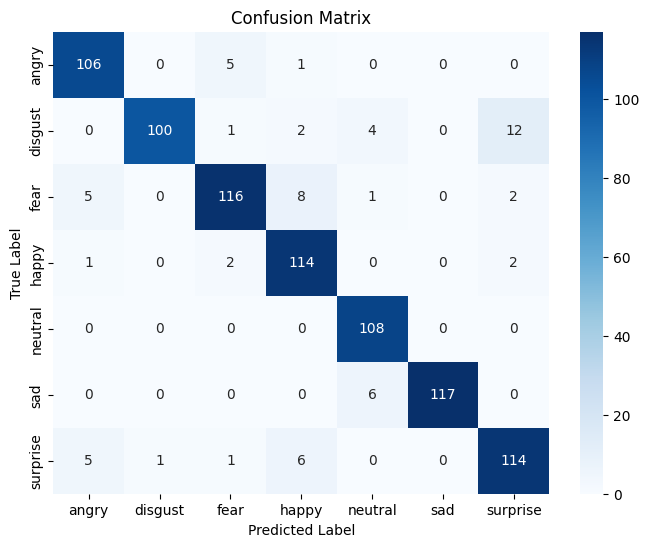

In [36]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

X = audio_features_df.drop(columns=["Path", "emotion", "MFCC", "Chroma", "Prosodic", "STFT", "FFT", "ZCR"]).values
y = audio_features_df["emotion"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

k = 3
knn = KNearestNeighbors(k=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Akurasi Model KNN:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Testing Model

In [51]:
def extract_features_from_audio(file_path):
    audio, sr = librosa.load(file_path)
    
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr, n_chroma=12).T, axis=0)  # 12 dimensi
    rms = np.mean(librosa.feature.rms(y=audio))
    duration = librosa.get_duration(y=audio, sr=sr)
    
    stft_values = np.abs(librosa.stft(audio))
    stft_mean = np.mean(stft_values)
    stft_std = np.std(stft_values)
    
    fft_values = np.abs(np.fft.fft(audio))
    fft_mean = np.mean(fft_values)
    fft_std = np.std(fft_values)
    
    zcr_values = librosa.feature.zero_crossing_rate(y=audio)
    zcr_mean = np.mean(zcr_values)
    zcr_std = np.std(zcr_values)
    
    features = np.hstack([
        mfcc,
        chroma, 
        [rms, duration], 
        [stft_mean, stft_std],  
        [fft_mean, fft_std],  
        [zcr_mean, zcr_std]  
    ])
    return features

sample_audio_path = "dataset/RAVDESS/Actor_01/03-01-07-02-01-02-01.wav"

sample_features = extract_features_from_audio(sample_audio_path)

sample_features = sample_features.reshape(1, -1)

predicted_emotion = knn.predict(sample_features)

print(predicted_emotion)

negative_emotions = ["angry", "sad", "fear", "disgust"]

if predicted_emotion in negative_emotions:
    print("Terdeteksi Depresi")

else :
    print("Normal")



['neutral']
Normal
